In [ ]:
import warnings

# sklearn의 force_all_finite → ensure_all_finite 메시지만 무시
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*force_all_finite.*"
)

In [ ]:
import boto3

from botocore import UNSIGNED
from botocore.config import Config

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

from denseclus import DenseClus
from denseclus.categorical import extract_categorical
from denseclus.numerical import extract_numerical

SEED = 42  # random seed to set reproducibility as best we can

sns.set_style("darkgrid")
sns.set_context("notebook")

%matplotlib inline

#### 데이터

공개되어 있는 *Census Income dataset*을 [https://archive.ics.uci.edu/ml/datasets/Adult](https://archive.ics.uci.edu/ml/datasets/Adult) 에서 다운로드하는 것부터 시작해봅시다. 

이 데이터셋에는 각 사람에 대해 나이, 직업 유형, 교육, 국가, 인종 등 다양한 속성이 있습니다. 또한, 연 수입이 \$50,000 이상인지를 나타내는 지표도 포함되어 있습니다. 

예측 과제는 한 사람이 연 \$50,000 이상을 버는지 여부를 판단하는 것입니다.

##### 데이터 설명

데이터에 대해 이야기해보겠습니다. 대략적으로 보면:

* 학습 데이터에는 15개의 열과 약 32,000개의 행이 있습니다.
* 14개 특성(feature) 중 8개는 범주형이고, 나머지 6개는 숫자형입니다.

이제 이것을 Pandas 데이터프레임으로 읽어서 살펴보겠습니다.

In [6]:
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
region = "us-east-1"

## read the data
s3.download_file(
    f"sagemaker-example-files-prod-{region}",
    "datasets/tabular/uci_adult/adult.data",
    "adult.data")

df = pd.read_csv("adult.data", header=None)

## set column names
df.columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "IncomeGroup",
]

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,IncomeGroup
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


데이터는 범주형과 숫자형 특성 모두로 구성되어 있는 것을 볼 수 있습니다.


일반적으로, 이는 [K-평균](https://en.wikipedia.org/wiki/K-means_clustering)과 같은 전통적인 차원 축소 및 클러스터링 방법에서는 문제가 됩니다.

이런 방법들은 입력 특성이 숫자형이기를 기대하고, 값들이 구형(spherical) 모양을 가진다고 가정하기 때문입니다.

#### 숫자형과 범주형 특성을 따로 나누어 클러스터를 만들기

숫자형과 범주형 특성을 각각 별도의 데이터셋으로 다루고, 각각 따로 클러스터링하면 어떻게 될까요?
한번 탐구해봅시다.

우리는 UMAP이라는 인기 있는 차원 축소 알고리즘과, HDBScan이라는 밀도 기반 클러스터링 알고리즘을 사용할 수 있습니다.

In [8]:
default_umap_params = {
    "categorical": {
        "metric": "hamming",
        "n_neighbors": 30,
        "n_components": 5,
        "min_dist": 0.0,
    },
    "numerical": {
        "metric": "l2",
        "n_neighbors": 30,
        "n_components": 5,
        "min_dist": 0.0,
    },
}

hdbscan_params = {
    "min_cluster_size": 100,
    "min_samples": 15,
    "gen_min_span_tree": True,
    "metric": "euclidean",
}

### Numerical features

/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


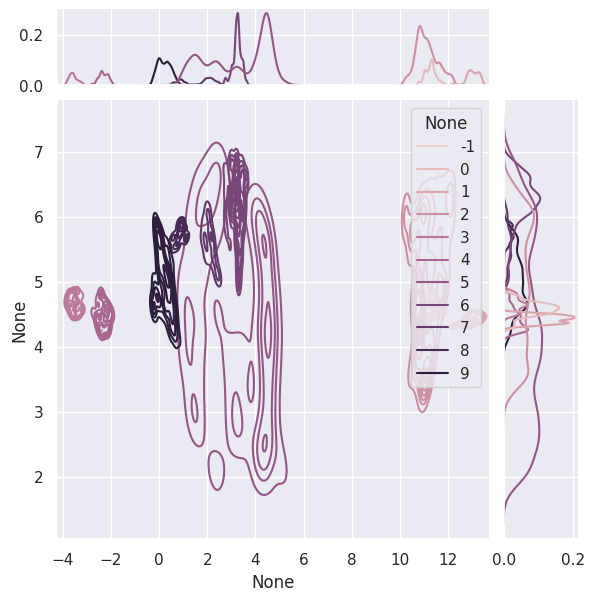

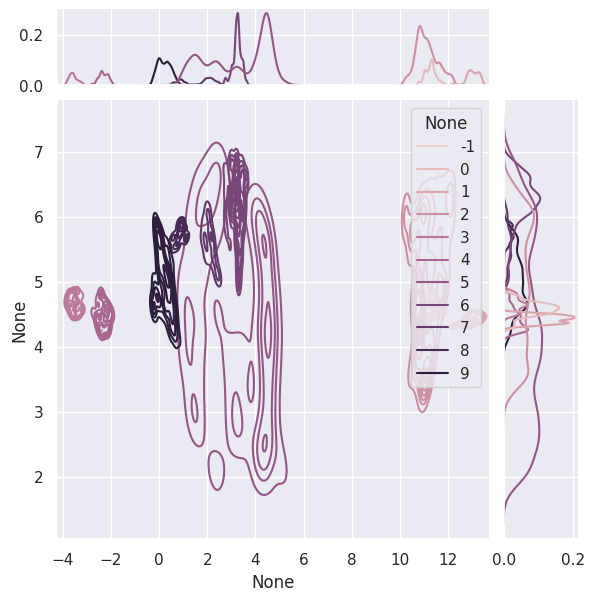

In [ ]:
numerical_df = extract_numerical(df)

numerical_umap = umap.UMAP(
    random_state=SEED,
    n_jobs=1,
    verbose=False,
    low_memory=True,
    **default_umap_params["numerical"],
).fit(numerical_df)

numerical_hdb = hdbscan.HDBSCAN(**hdbscan_params).fit(numerical_umap.embedding_)

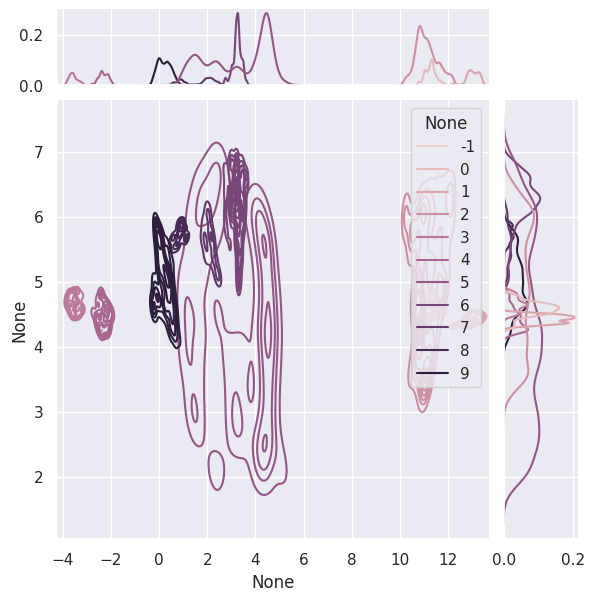

In [13]:
joint_plot = sns.jointplot(
    x=numerical_umap.embedding_[:, 0],
    y=numerical_umap.embedding_[:, -1],
    hue=numerical_hdb.labels_,
    kind="kde",
    marginal_ticks=True,
)

plt.show()

In [14]:
numerical_df = df.select_dtypes(include=[int, float])
numerical_df["segment"] = numerical_hdb.labels_

numerical_df.groupby(["segment"]).agg(["mean", "median"])

age                fnlwgt           education-num         \
              mean median           mean    median          mean median   
segment                                                                   
-1       31.844444   30.0  249535.011111  201015.0      5.766667    6.0   
 0       43.475871   42.0  191109.560992  177930.0      9.019437    9.0   
 1       44.677049   43.0  184376.141803  173794.5     13.568852   13.0   
 2       39.534438   38.0  186977.408006  177351.0     13.268461   13.0   
 3       43.095385   42.0  189698.656923  176468.0     13.595385   13.0   
 4       40.657439   40.0  182489.782007  173858.0      8.995386    9.0   
 5       37.627044   36.0  188678.565600  177392.5      9.473123    9.0   
 6       34.942626   26.0  191874.512804  181096.0      9.554295   10.0   
 7       17.870528   17.0  178490.265758  170544.0      6.788756    7.0   
 8       59.930723   63.0  184803.156627  179670.0      4.722892    4.0   
 9       40.266328   38.0  206821.163473  193490.0      5.146265    5.0   

         capital-gain         capital-loss         hours-per-week         
                 mean  median         mean  median           mean median  
segment                                                                   
-1           0.000000     0.0    38.933333     0.0      29.255556   30.0  
 0        8439.495308  4416.0     0.000000     0.0      41.333110   40.0  
 1       18440.653279  7688.0     0.000000     0.0      46.172951   45.0  
 2           0.000000     0.0     0.000000     0.0      42.340787   40.0  
 3           0.000000     0.0  1917.029231  1902.0      45.683077   43.0  
 4           0.000000     0.0  1837.516724  1887.0      41.498270   40.0  
 5           0.000000     0.0     0.000000     0.0      43.768495   40.0  
 6           0.000000     0.0     0.000000     0.0      21.722528   21.0  
 7           0.000000     0.0     0.000000     0.0      18.446337   20.0  
 8           0.000000     0.0     0.000000     0.0      18.972892   20.0  
 9           0.000000     0.0     0.000000     0.0      42.094642   40.0

* **클러스터 1**은 연령이 더 낮고, 교육 수준·수입(fnlwgt)·근로 시간이 모두 낮은 집단을 나타내는 것 같습니다. 학생이나 사회 초년생일 수 있습니다.
* **클러스터 0, 1, 2, 4, 7, 9**는 중년의 직장인 집단으로, 교육 수준·수입·근로 시간이 모두 높은 경향을 보입니다.
* **클러스터 5**는 명확하게 매우 젊은 집단을 포착하고 있는데, 낮은 나이와 근로 시간을 볼 때 십대나 학생일 가능성이 높습니다.
* **클러스터 6**은 경력 초반의 성인으로, 교육과 수입이 중간 정도인 사람들로 보입니다.
* **클러스터 8**은 연령이 많고 은퇴한 사람들을 대표하는데, 이들은 교육, 수입, 근로 시간 모두가 낮은 특징을 보입니다.

**숫자형 특성만을 사용했을 때의 한계점:**

* 직업, 결혼 여부 등과 같은 범주형 특성(맥락 정보)이 부족하여 클러스터를 더 명확하게 구분하는 데 어려움이 있습니다.
* 클러스터는 오직 숫자형 특성들의 중심 경향(평균값 등)에 따라 형성됩니다. 하지만 한 클러스터 내에도 서로 매우 다른 하위 집단이 존재할 수 있습니다.
* 데이터에 존재하는 중요한 이상치(outlier)가 클러스터 내에서 제대로 반영되지 않을 수 있습니다.
* 숫자형 특성만으로는 더 복잡한 행동적 세분화(behavioral segments)를 완전히 포착하기 어렵습니다.

따라서, 숫자형 특성만으로도 흥미로운 초기 프로필을 알 수 있지만, 범주형·행동 특성을 추가하면 더 미묘하고 의미 있는 고객 세그먼트를 만들 수 있을 것입니다.


### Categorical features

In [15]:
categorical_df = extract_categorical(df)

categorical_umap = umap.UMAP(
    random_state=SEED,
    n_jobs=1,
    verbose=False,
    low_memory=True,
    **default_umap_params["categorical"],
).fit(categorical_df)

categorical_hdb = hdbscan.HDBSCAN(**hdbscan_params).fit(categorical_umap.embedding_)
n_clusters = len(np.unique(categorical_hdb.labels_))
print(f"Number of clusters: {n_clusters}")

Max of 42 is greater than threshold 25
Hashing categorical features


/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters: 112


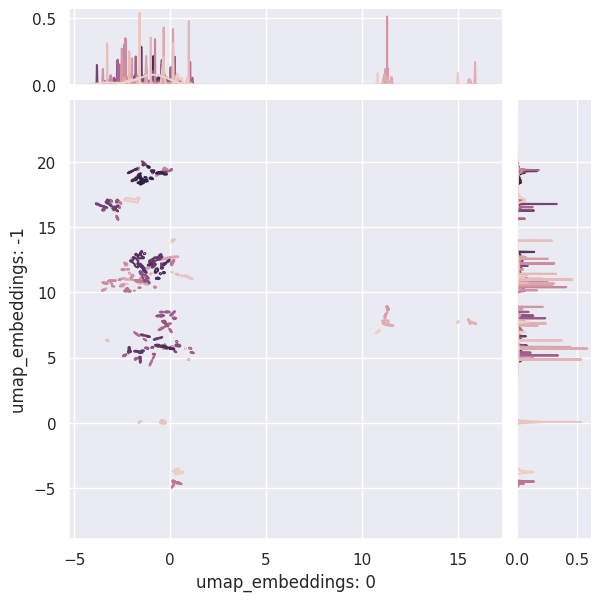

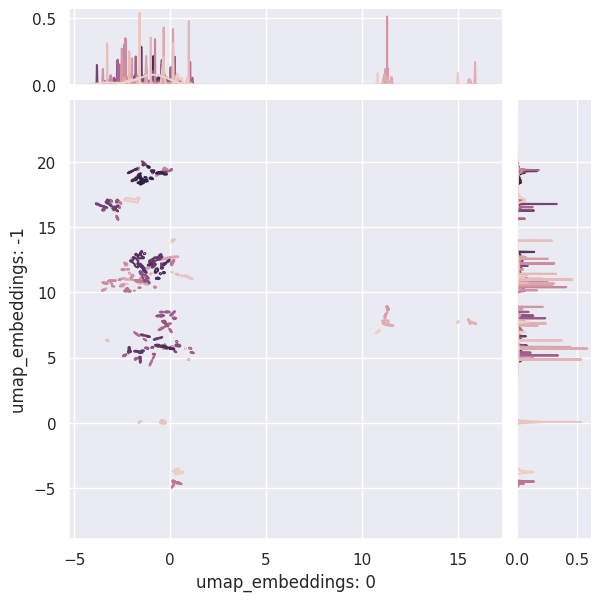

In [17]:
joint_plot = sns.jointplot(
    x=categorical_umap.embedding_[:, 0],
    y=categorical_umap.embedding_[:, -1],
    hue=categorical_hdb.labels_,
    kind="kde",
    marginal_ticks=True,
)
joint_plot.ax_joint.legend_.remove()
joint_plot.set_axis_labels("umap_embeddings: 0", "umap_embeddings: -1")

plt.show()

In [18]:
categorical_df = df.select_dtypes(include=[object])
categorical_df["segment"] = categorical_hdb.labels_

categorical_df.groupby("segment").describe(include="object").tail(10)

workclass                                education         \
            count unique                top freq     count unique   
segment                                                             
101           121      1            Private  121       121     10   
102           179      5            Private  163       179     11   
103           195      6            Private  176       195     12   
104           179      6            Private  114       179      4   
105           299      6            Private  108       299     10   
106           115      6            Private   62       115      8   
107           298      4            Private  291       298     12   
108           163      3   Self-emp-not-inc  156       163     12   
109           200      6            Private  155       200     11   
110           135      5            Private  110       135      4   

                            marital-status         ...    sex       \
                   top freq          count unique  ...    top freq   
segment                                            ...               
101            HS-grad   65            121      2  ...   Male  121   
102            HS-grad   97            179      4  ...   Male  179   
103            HS-grad  109            195      4  ...   Male  195   
104       Some-college  174            179      4  ...   Male  179   
105          Bachelors  103            299      4  ...   Male  299   
106          Bachelors   49            115      1  ...   Male  115   
107            HS-grad  159            298      3  ...   Male  298   
108            HS-grad   77            163      5  ...   Male  163   
109       Some-college   95            200      2  ...   Male  200   
110            HS-grad  132            135      2  ...   Male  135   

        native-country                             IncomeGroup                 \
                 count unique             top freq       count unique     top   
segment                                                                         
101                121      7   United-States  111         121      2   <=50K   
102                179     17   United-States  141         179      2   <=50K   
103                195     12   United-States  175         195      2   <=50K   
104                179     10   United-States  162         179      1   <=50K   
105                299     18   United-States  262         299      2   <=50K   
106                115      7   United-States  107         115      1   <=50K   
107                298      6   United-States  292         298      1   <=50K   
108                163      9   United-States  150         163      2   <=50K   
109                200      6   United-States  193         200      1   <=50K   
110                135      6   United-States  130         135      1   <=50K   

              
        freq  
segment       
101      119  
102      178  
103      193  
104      179  
105      293  
106      115  
107      298  
108      154  
109      200  
110      135  

[10 rows x 36 columns]

위의 플롯(그래프)에서, 범주형 특성만을 사용하여 클러스터를 만든 결과를 보면 다음과 같은 점을 알 수 있습니다:

* 범주형 특성만으로 114개의 클러스터가 만들어졌으며, 이로 인해 서로 매우 비슷한 클러스터가 많이 생깁니다.
* 희소성(sparsity)이 높습니다. 범주형 특성은 흔히 고차원 희소 공간을 만들어내는데, 이렇게 되면 통계적으로 의미 있는 클러스터링이 어려워집니다. 114개의 클러스터가 넓고 희소한 공간에 형성되면서, 대부분의 클러스터에는 데이터가 몇 개만 들어가게 됩니다.
* 클러스터 해석이 어렵습니다. 범주형 특성만으로 생성된 클러스터는 성격을 명확히 파악하거나 해석하기가 힘듭니다.

요약하자면, 오직 범주형 특성만으로 클러스터링을 하면 명확한 의미나 클러스터 간 차별성이 부족한 경우가 많습니다.
숫자형 특성과 결합해서 사용해야 더 본질적인 구조를 반영할 수 있기 때문에, 보통 혼합해서 쓸 때 더 효과적입니다.

### DenseClus를 이용한 모든 특성(숫자형 + 범주형) 클러스터링

DenseClus를 사용하면 이런 문제가 발생하지 않습니다.
이유는, DenseClus가 범주형과 숫자형 각각에 대해 UMAP 임베딩을 만들고, 이 임베딩 공간을 결합해서 가장 조밀한(dense) 공간을 만들어내기 때문입니다.
이후에 HDBSCAN을 돌려서 밀도 기반으로 클러스터를 뽑아내면, 혼합형 데이터를 잘 반영한 그룹들이 만들어집니다.

이 모든 과정은 내부적으로 자동으로 처리되고, 아래와 같이 `fit` 함수 한 줄만 호출하면 됩니다.

### 임베딩 공간을 결합하는 5가지 방법이 있습니다 (파라미터: umap\_combine\_method, 기본값=intersection)

* 'intersection' (교집합)
* 'union' (합집합)
* 'contrast' (대조)
* 'intersection\_union\_mapper' (교집합/합집합 매퍼)
* 'ensemble' (앙상블)

---

위의 각 방법을 실제로 구현해서, 각각의 umap 임베딩을 시각화해봅시다.

In [21]:
def plot_clusters(method, embeddings, clusters):
    """display KDE plots for given embeddings/clusters"""

    joint_plot = sns.jointplot(
        x=embeddings[:, 0], y=embeddings[:, -1], hue=clusters, kind="kde", marginal_ticks=True
    )
    joint_plot.set_axis_labels("umap_embeddings: 0", "umap_embeddings: -1")

    joint_plot.figure.suptitle(f"Method: {method}")
    if n_clusters > 50:
        joint_plot.ax_joint.legend_.remove()
    
    plt.show()

Running combination method: intersection
Max of 42 is greater than threshold 25
Hashing categorical features


/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Coverage 0.9112435121771444
Calinski-Harabasz Score: 12529.076809132519
Number of clusters: 31


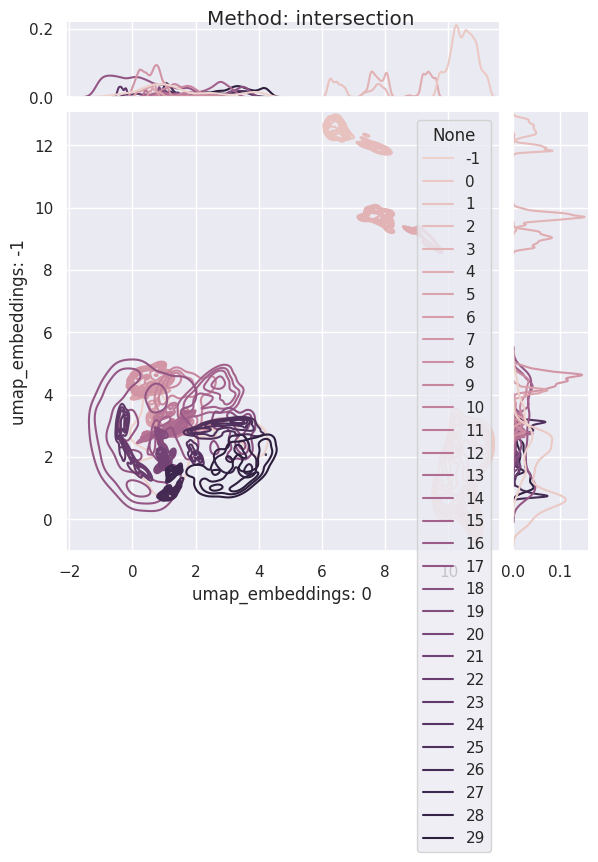

------------------------------
Running combination method: union
Max of 42 is greater than threshold 25
Hashing categorical features


/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Coverage 0.8291514388378736
Calinski-Harabasz Score: 1886.611111560289
Number of clusters: 115


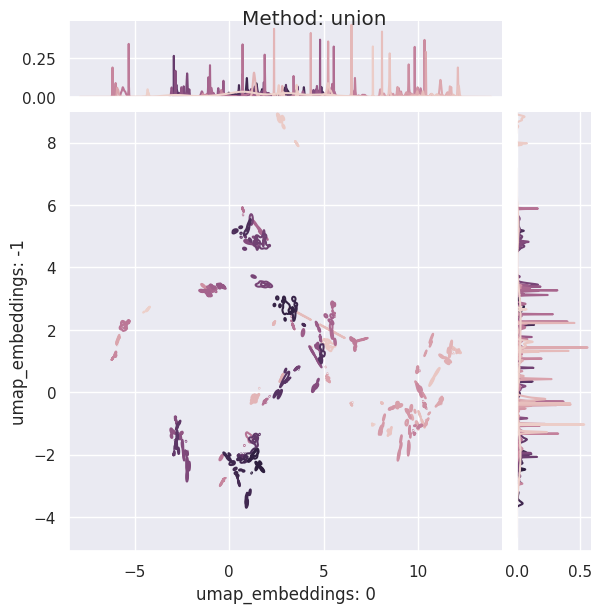

------------------------------
Running combination method: contrast
Max of 42 is greater than threshold 25
Hashing categorical features


/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Coverage 0.9289026749792697
Calinski-Harabasz Score: 23606.20366322475
Number of clusters: 28


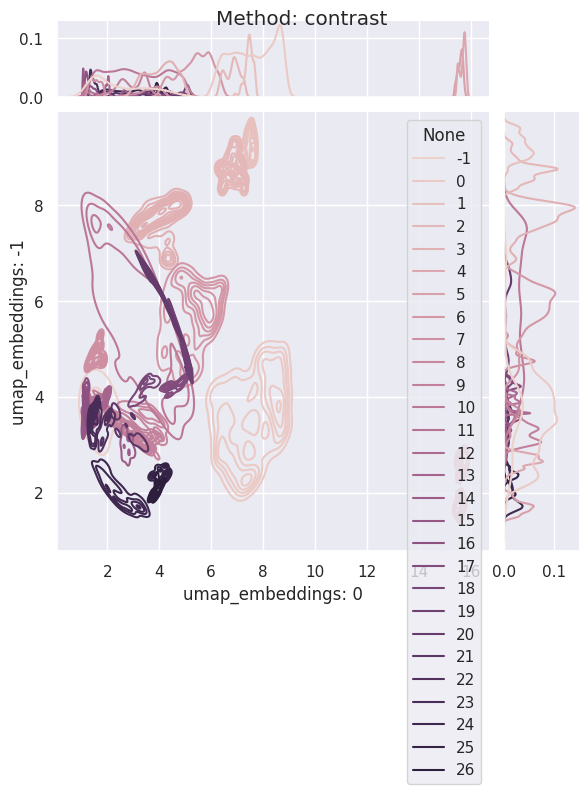

------------------------------
Running combination method: intersection_union_mapper
Max of 42 is greater than threshold 25
Hashing categorical features


/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:1

Coverage 0.9924756610669205
Calinski-Harabasz Score: 61791.0279460716
Number of clusters: 6


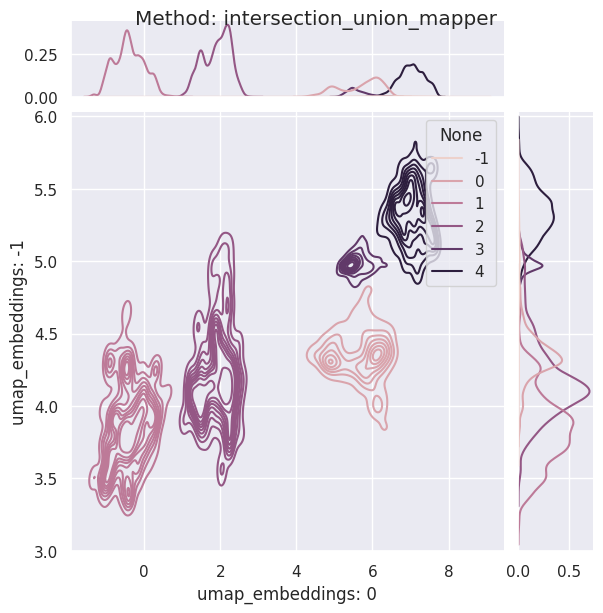

------------------------------
Running combination method: ensemble
Max of 42 is greater than threshold 25
Hashing categorical features


/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:1

Coverage 0.9992014987254692
Calinski-Harabasz Score: 278.06418436522927
Number of clusters: 112


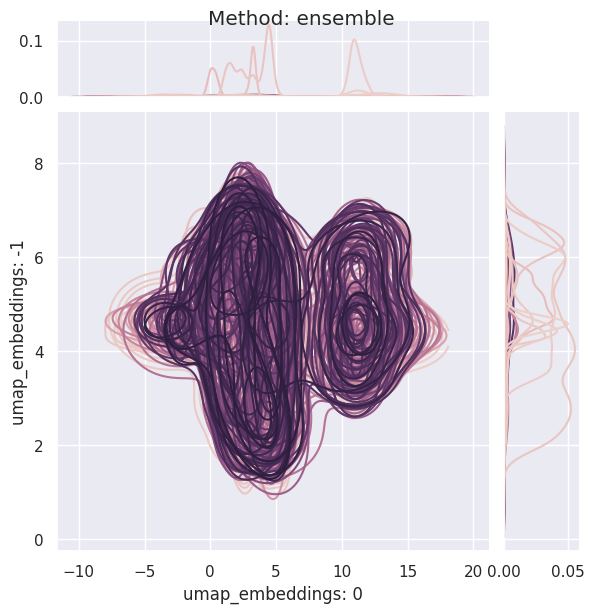

------------------------------


In [22]:
methods = ["intersection", "union", "contrast", "intersection_union_mapper", "ensemble"]

hdbscan_params = {
    "min_cluster_size": 200,
    "min_samples": 30,
    "gen_min_span_tree": True,
    "metric": "manhattan",
    "cluster_selection_method": "eom",
}


for method in methods:
    print(f"Running combination method: {method}")
    clf = DenseClus(random_state=SEED, umap_combine_method=method)
    clf.fit(df)
    clusters = clf.evaluate()
    n_clusters = len(np.unique(clusters))
    print(f"Number of clusters: {n_clusters}")

    if hasattr(clf, "mapper_"):
        embeddings = clf.mapper_.embedding_
    else:
        embeddings = clf.numerical_umap_.embedding_

    plot_clusters(method, embeddings, clusters)

    print("-" * 30)

----------
정리하자면, 지금까지의 흐름은 다음과 같습니다:
1. 숫자형 특성들을 분리해서 *조밀한(dense)* UMAP 임베딩으로 줄였습니다.

2. 범주형 특성들도 따로 뽑아서 *조밀한* 별도의 UMAP 임베딩을 만들었습니다.

3. 두 임베딩을, 위에서 설명한 연산 방법 중 하나(“intersection”, “union”, “contrast”, “intersection\_union\_mapper”, “ensemble”)로 결합했습니다.

4. 결합된 공간에서 HDBSCAN이 밀도 기반 공간 클러스터링을 계층적 방식으로 돌려서 클러스터를 뽑았습니다.

이제, 이 특성과 임베딩 정보들은 `DenseClus` 객체에서 확인할 수 있습니다.

#### 분석:

각 방법의 위 결과에 근거해 볼 때, `intersection_union_mapper`가 우리의 데이터셋을 클러스터링하는 데 가장 적합한 방법으로 보입니다. 위에서 볼 수 있듯이, 데이터의 단면(slice) 안에 5개의 뚜렷한 “섬(islands)”이 형성되어 있습니다. 클러스터들이 이런 밀도(density)를 중심으로 모여 있는데, 바로 이것이 DenseClus에서 기대하는 동작입니다.

`intersection_union_mapper`는 'intersection'과 'union' 두 가지 방법의 장점을 결합한 하이브리드 방식입니다.
먼저 'intersection' 방식을 적용하여 숫자형 임베딩을 보존하고, 이후 'union' 방식을 적용해 범주형 임베딩을 보존합니다.
이 방법은 숫자형 데이터와 범주형 데이터 모두가 중요한 경우에 유용하며, 어느 한 쪽이 더 중요하지 않은 경우에도 사용할 수 있습니다.

이제 intersection\_union\_mapper 방식의 임베딩 결과를 더 깊게 들여다봅시다:

In [23]:
ium_clf = DenseClus(random_state=SEED, umap_combine_method="intersection_union_mapper")
ium_clf.fit(df)

labels = ium_clf.evaluate()

Max of 42 is greater than threshold 25
Hashing categorical features


/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/station_05/anaconda3/envs/torch_ev/lib/python3.11/site-packages/sklearn/utils/deprecation.py:1

Coverage 0.9924756610669205
Calinski-Harabasz Score: 61791.0279460716


#### 임베딩 결과 확인

이제 임베딩들이 조밀하게(densely) 잘 형성되었는지 확인합니다.

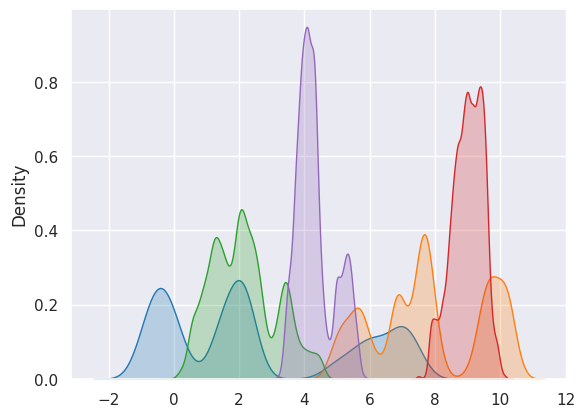

In [24]:
for i in range(len(ium_clf.mapper_.embedding_[0])):
    sns.kdeplot(ium_clf.mapper_.embedding_[:, i], fill=True)

plt.show()

##### 클러스터 결과 점검

내부적으로 DenseClus는 여러 단계 중에서, 데이터를 클러스터링할 때 HDBSCAN을 사용합니다.

데이터가 어떻게 분할되었는지 살펴봅시다.

In [25]:
cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"]))

   cluster  count
5       -1    245
3        0   3983
1        1  10787
0        2  11295
4        3    935
2        4   5316


조사해 보면, 정확히 5개의 클러스터가 있으며, -1은 데이터 내에서 발견된 “노이즈(noise)”를 의미합니다.

##### 클러스터 프로파일링

마지막으로 클러스터가 형성된 후에는, 각 클러스터가 무엇을 의미하는지 설명하는 것이 일반적입니다.

여기서는, 기술 통계(descriptive statistics)가 실제로 매우 강력하고(그리고 효율적인) 도구로 사용됩니다.

그룹 `-1`은 무시합시다. 이 데이터포인트들은 어떤 클러스터에도 속하지 않은 값들입니다.

In [26]:
df["segment"] = labels
clustered_results = df[df.segment > -1]

In [27]:
numerics = clustered_results.select_dtypes(include=[int, float])
numerics.groupby("segment").mean()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
segment,,,,,,
0,42.847853,179412.861160,13.338187,3323.917148,153.796134,44.304544
1,38.953277,189857.745064,8.974043,570.314360,69.823120,40.596551
2,36.674546,193271.483134,8.421691,479.322798,65.025675,37.895263
3,36.736898,195593.336898,12.004278,517.714439,63.948663,40.713369
4,38.919676,187705.232129,12.979120,1726.089353,113.929458,42.454853


범주형 특성에 대해서도 비슷한 유형의 분석이 가능합니다:

In [28]:
categorical = df.select_dtypes(include=["object"])
categorical["segment"] = clustered_results.segment
categorical.groupby("segment").describe(include=["object"]).T

segment                                0.0                  1.0  \
workclass      count                  3983                10787   
               unique                    7                    9   
               top                 Private              Private   
               freq                   2282                 7989   
education      count                  3983                10787   
               unique                    8                    8   
               top                 Masters              HS-grad   
               freq                   1680                10490   
marital-status count                  3983                10787   
               unique                    7                    7   
               top      Married-civ-spouse   Married-civ-spouse   
               freq                   2371                 4968   
occupation     count                  3983                10787   
               unique                   15                   15   
               top          Prof-specialty         Craft-repair   
               freq                   1763                 1978   
relationship   count                  3983                10787   
               unique                    6                    6   
               top                 Husband              Husband   
               freq                   2123                 4377   
race           count                  3983                10787   
               unique                    5                    5   
               top                   White                White   
               freq                   3550                 9112   
sex            count                  3983                10787   
               unique                    2                    2   
               top                    Male                 Male   
               freq                   2823                 7325   
native-country count                  3983                10787   
               unique                   39                   41   
               top           United-States        United-States   
               freq                   3565                 9925   
IncomeGroup    count                  3983                10787   
               unique                    2                    2   
               top                    >50K                <=50K   
               freq                   2030                 9079   

segment                           2.0                  3.0  \
workclass      count            11295                  935   
               unique               9                    7   
               top            Private              Private   
               freq              8105                  674   
education      count            11295                  935   
               unique              13                    3   
               top       Some-college           Assoc-acdm   
               freq              7285                  932   
marital-status count            11295                  935   
               unique               7                    7   
               top      Never-married   Married-civ-spouse   
               freq              4466                  400   
occupation     count            11295                  935   
               unique              15                   14   
               top      Other-service         Adm-clerical   
               freq              1603                  179   
relationship   count            11295                  935   
               unique               6                    6   
               top            Husband              Husband   
               freq              3851                  336   
race           count            11295                  935   
               unique               5                    5   
               top              White                White   
               freq             

#### Conclusion

이 노트북에서는 DenseClus를 사용하여 혼합형(mixed-type) 데이터에서 고품질 클러스터를 만드는 방법과 그 이유를 단계별로 다루었습니다.
혼합형 데이터의 정보를 결합하는 5가지 방법(“intersection”, “union”, “contrast”, “intersection_union_mapper”, “ensemble”)을 탐색하고, 각각의 성능을 비교해보았습니다.

여러분의 데이터셋에 DenseClus를 적용할 때, 다양한 결합(combine) 방법과 하이퍼파라미터 조합을 실험해서 어떤 방식이 여러분의 데이터에서 가장 잘 작동하는지 확인해보시기 바랍니다.